# Analisis extra
Acá se analizan los datos por fuera de los requerimientos principales

Primero se procede con importar librerias y datos

In [113]:
#Importar librerias a usar
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import plotly.express as px
import zepid
from zepid.graphics import EffectMeasurePlot
import networkx as nx
from numpy import genfromtxt

#Creación de data frames a usar
df_metadata = pd.read_csv('..\data\cleaned\Tabla Normalizada - Metadata.csv')
df_data_type = pd.read_csv('..\data\cleaned\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('..\data\cleaned\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('..\data\cleaned\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('..\data\cleaned\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('..\data\cleaned\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('..\data\cleaned\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('..\data\cleaned\Tabla Normalizada - Performances.csv')
df_alg_perf = pd.read_csv('..\data\cleaned\Tabla Normalizada - Alg_Perf.csv')

# Set características generales de los gráficos

In [114]:
plt.rcParams['figure.figsize'] = [20, 10]

sns.set_style("darkgrid")
sns.set_palette('colorblind')

plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20

Funciones

In [115]:
def multi_reversing(df,col_id, col_values):
    """la funcion toma nos da la frecuencia de los datos distribuidos en distintas columnas.
    Toma una variable distribuida en varias columnas (one hot encoding), y aplica la funcion melt para cambiar el formato
    de la tabla a long. Luego devuelve una columna donde aparece el nombre de cada columna, la cantidad de veces que fue
    marcada con una 'x' (si accuracy fue marcada 50 veces, aparecera el str 'accuracy' 50 veces, lo que permite graficar su frecuencia
    de aparicion)

    Args:
        df (dataframe): dataframe con el que se desea trabajar, debe poseer las columnas de id_vars y list_value_vars
        in_id_vars (str): nombre de la columna que se usa como identificador de variables 
        value_vars (str o lista): str o lista con el nombre de las columnas de las cuales se desea obtener los datos (se puede
        obviamente subsetear (p.e. dataframe.iloc['columna_1',...,columna_n']))

    Returns:
        dataframe: _description_
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value == 'x']

def multi_reversing_n(df,col_id, col_values):
    """exactamente lo mismo que multi_reversing, solo que para casos donde lo que se busca es un numero y no una x
    """
    df_raw = pd.melt(df, id_vars = col_id, value_vars = col_values)
    return df_raw[df_raw.value != 0]

## a. Frecuencia de papers por tipo de source (conference, journal, pre-print)

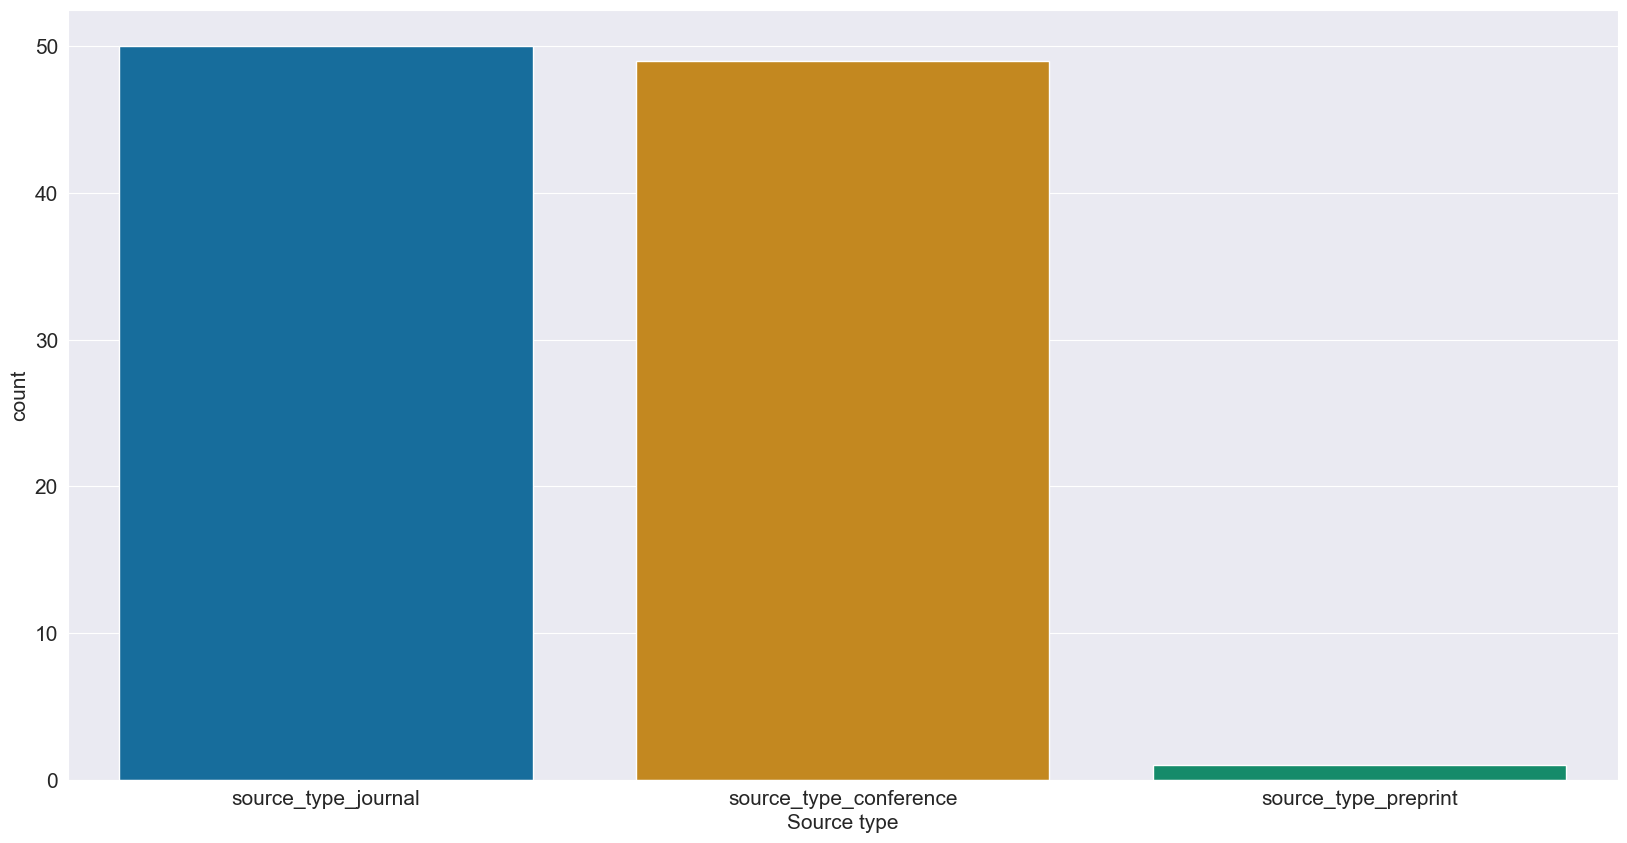

In [116]:
df_metadata=df_metadata.fillna('-')
df_metadata_sin_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_sources = df_metadata_sin_duplicates.iloc[:,7:10]
def get_value(row):
     for c in df_sources.columns:
         if row[c]== 'x':
             return c

df_sources = df_sources.apply(get_value, axis=1)
df_sources = pd.DataFrame(df_sources)
df_sources.columns = ['Source type']

#ploteo
quantity = df_sources['Source type'].value_counts()
df_quantity = pd.DataFrame(quantity)


sns.countplot(x='Source type', data=df_sources)
plt.show()

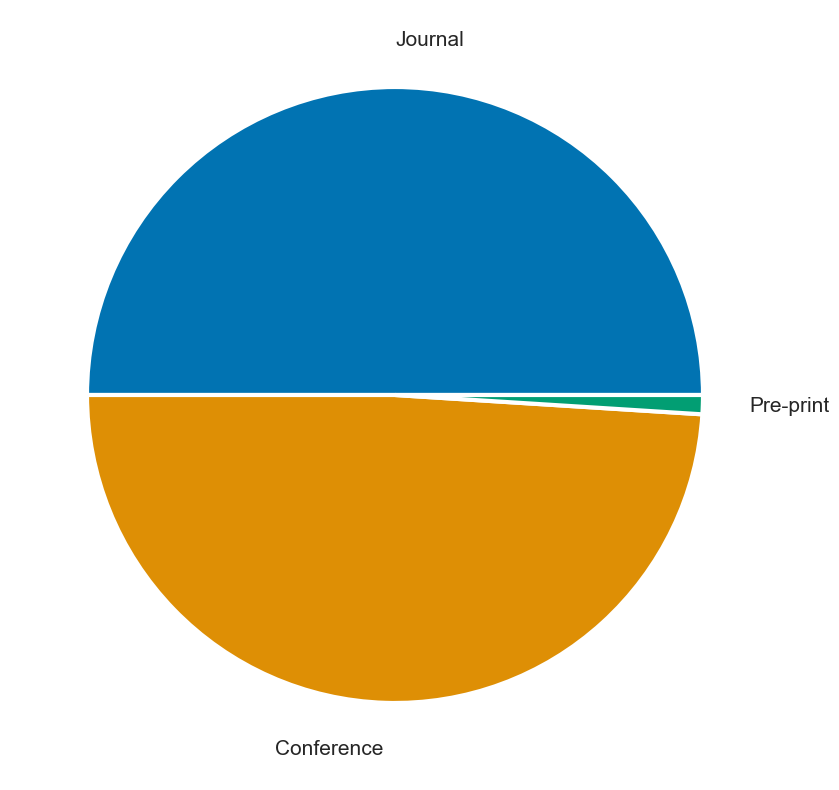

In [117]:
#pie plot

names = 'Journal', 'Conference', 'Pre-print'
plt.pie(df_quantity['Source type'], labels = names, labeldistance = 1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.show()

# b. Gráfico de barras papers por país y continente
Interpretación: primacía de trabajos provenientes de China y Asia. Seguidos estos por trabajos europeos.

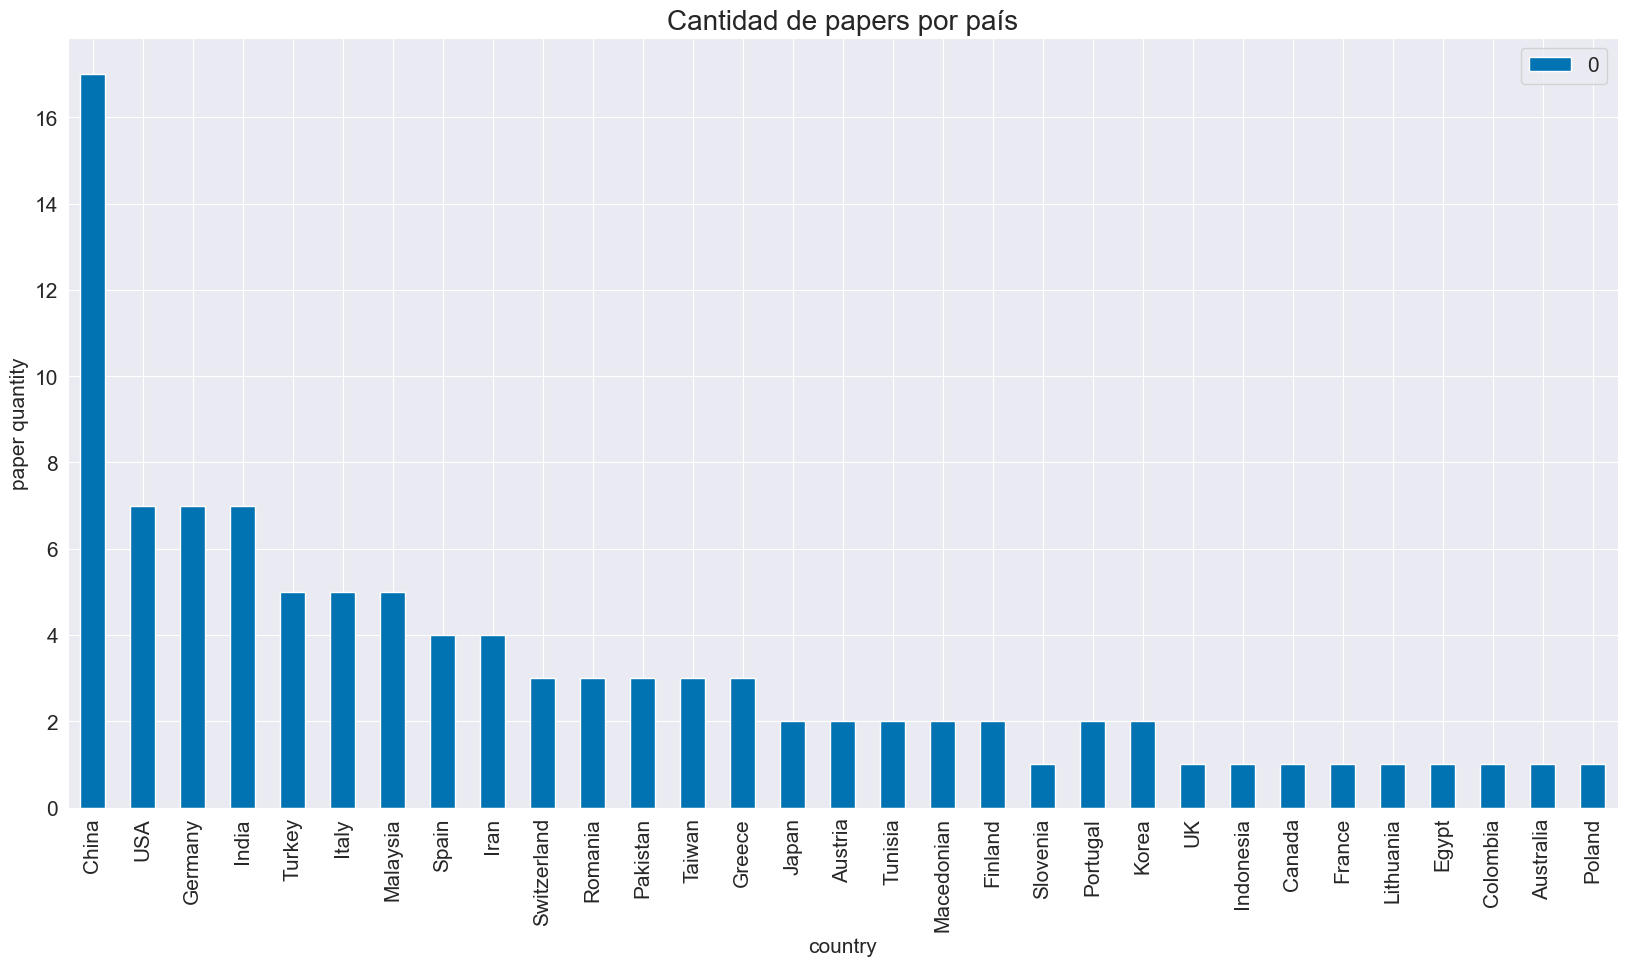

  continents  quantity
0       Asia        49
1     Europa        39
2    America         9
3     Africa         3
4  Australia         1


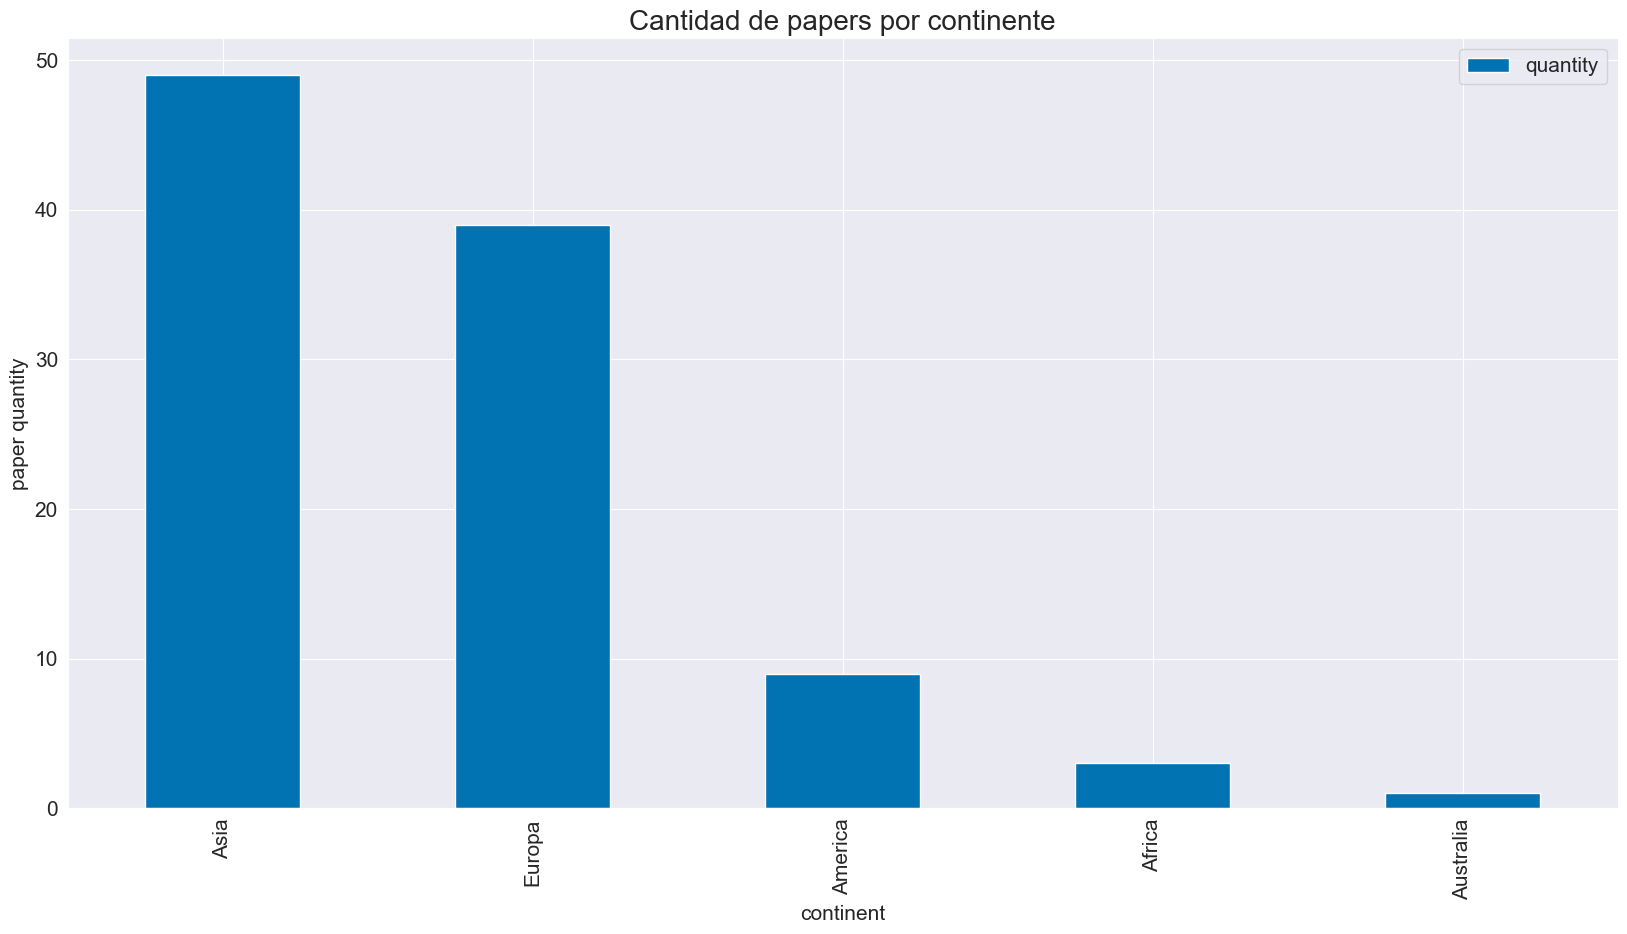

In [118]:
paises = df_metadata_sin_duplicates["first_author_country_affiliation"].unique()

countries = df_metadata_sin_duplicates.pivot_table(columns=['first_author_country_affiliation'], aggfunc='size')
df_countries = pd.DataFrame(countries)

order = ['China','USA', 'Germany', 'India','Turkey','Italy', 'Malaysia','Spain','Iran', 'Switzerland','Romania','Pakistan', 'Taiwan','Greece', 'Japan',
'Austria', 'Tunisia','Macedonian', 'Finland', 'Slovenia', 'Portugal', 'Korea',
'UK', 'Indonesia','Canada', 'France', 'Lithuania', 
'Egypt','Colombia', 'Australia', 'Poland']

df_countries.loc[order].plot(kind='bar', title='Cantidad de papers por país', xlabel='country', ylabel='paper quantity')
plt.show()

#Papers por continente - plot
papers_continents = {'continents' : ['Asia', 'Europa','America','Africa','Australia'],
'quantity' : [49, 39, 9, 3, 1]}
df_continents = pd.DataFrame(papers_continents)
print(df_continents)

df_continents.set_index('continents').plot(kind='bar', title='Cantidad de papers por continente', xlabel='continent', ylabel='paper quantity')
plt.show()


In [119]:
#pycountry.countries.get(name="spain")#ESP

#df_countries.loc[order].plot(kind='bar', title='Cantidad de papers por país', xlabel='country', ylabel='paper quantity')
#plt.show()

#df_paises = pd.read_excel('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Paises.xlsx')
df_countries1 = df_countries.index

def get_alpha_3(location):
    try:
        return pycountry.countries.get(name=location).alpha_3
    except:
        return None

df_countries.reset_index(inplace = True, drop = True)
df_countries['country'] = df_countries1



df_countries = df_countries.replace('Korea','Korea, Republic of')
df_countries = df_countries.replace('Iran','Iran, Islamic Republic of')
df_countries = df_countries.replace('UK','United Kingdom')
df_countries = df_countries.replace('USA','United States')
df_countries = df_countries.replace('Macedonian','North Macedonia')

df_countries["code"] = df_countries["country"].apply(lambda x: get_alpha_3(x))

fig = px.choropleth(df_countries,
                    locations="code",
                    color=0,
                    hover_name="country",
                    title = "Cantidad de papers por pais")

#fig.show()

#CSV archive to Tableau
df_countries.to_csv("..\data\cleaned\Countries.csv")


# c. Grafico base de datos, privadas y composicion de publicas

Incluir en un grafico, dentro de las bases de datos publicas, cada base de dato publica (AMIGOS, MAHNOB, etc.)

* cantidad total bases de datos: 101 (igual que la cantidad de papers, suponiendo que es solo un uso de base de datos por paper, que los papers 37 y 62 no siguen)
    * db privada: 58
    * db databases: 38
        * DEAP 10
        * MAHNOB 7
        * AMIGOS 7
        * PMEmo 3
        * Ascertein 2
        * RECOLA 2
        * Otros 7
    * db publica: 3
    * db uppon request: 1

Teniendo en cuenta la divergencia de los papers 37 y 62

* cantidad total bases de datos: 107 (101 + 6)
    * db privada: 58
    * db databases: 44
        * DEAP 11
        * MAHNOB 9
        * AMIGOS 8
        * PMEmo 3
        * Ascertein 2
        * RECOLA 2
        * Otros 9
    * db publica: 3
    * db uppon request: 1

Gráfico realizado en Tableau

    use_multiple_db db_private db_public db_private_and_public  \
0                 -          x         -                     -   
1                 -          x         -                     -   
2                 -          -         -                     -   
4                 -          -         -                     -   
9                 -          x         -                     -   
..              ...        ...       ...                   ...   
481               -          -         -                     -   
491               -          x         -                     -   
492               -          -         -                     -   
494               -          -         -                     -   
498               -          x         -                     -   

    db_uppon_request  
0                  -  
1                  -  
2                  -  
4                  -  
9                  -  
..               ...  
481                -  
491                -  


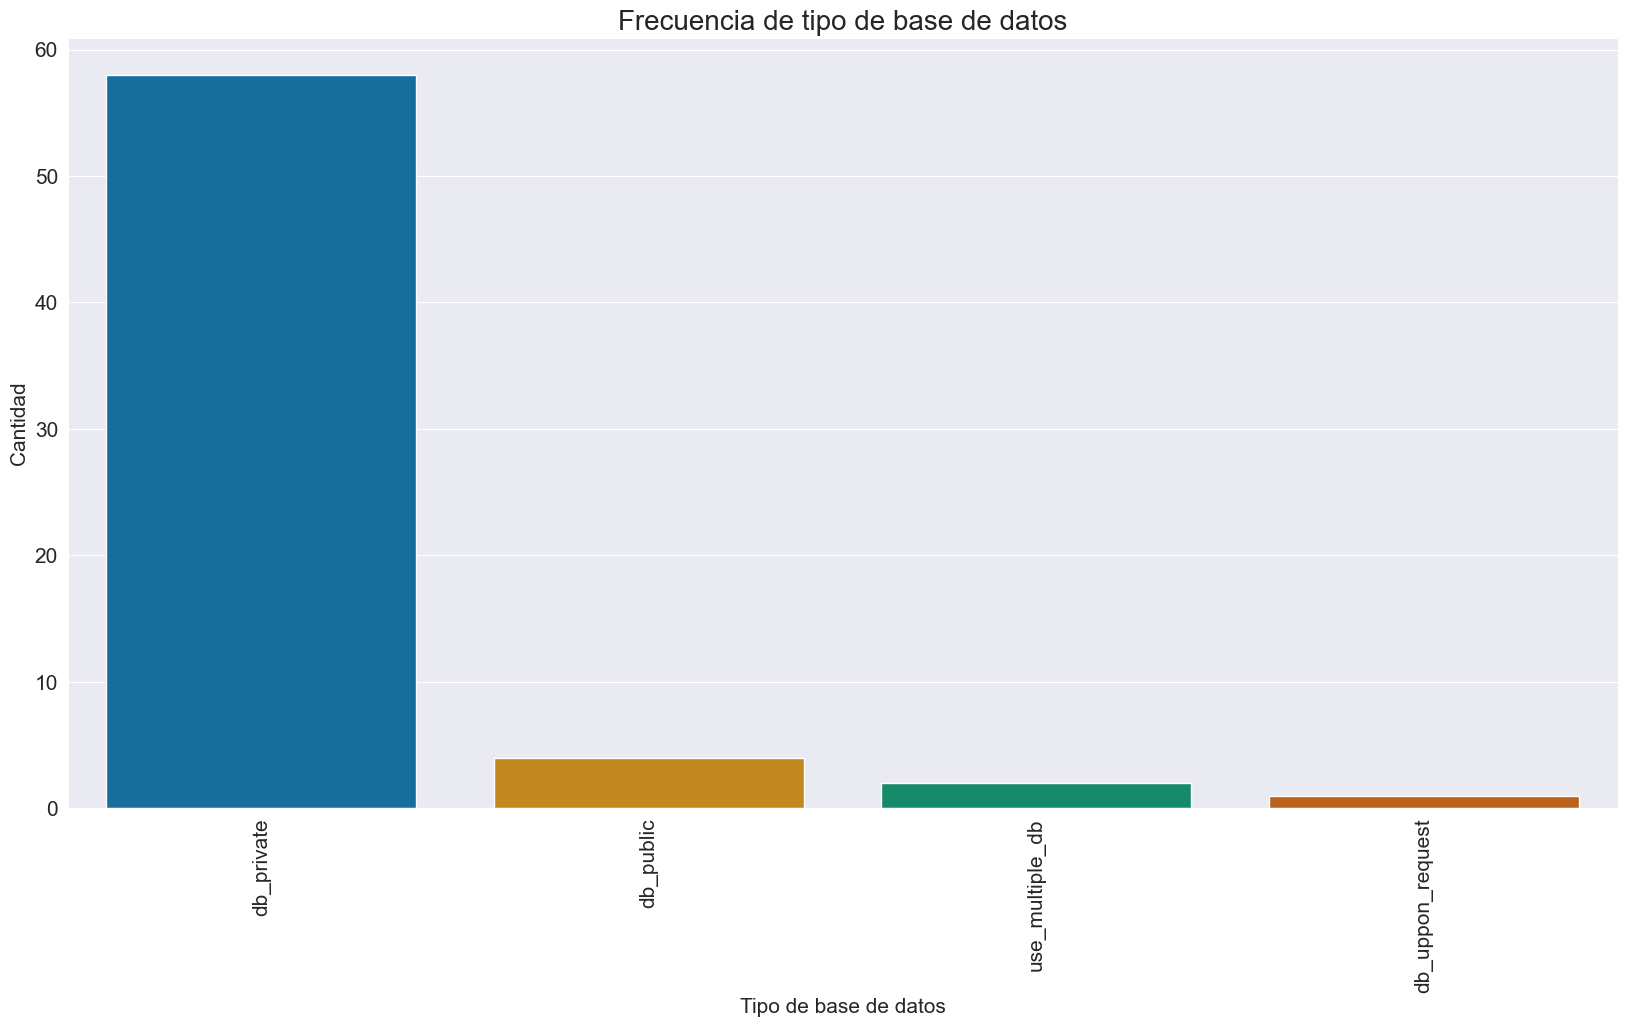

Database type   
db_private          58
db_public            4
use_multiple_db      2
db_uppon_request     1
dtype: int64


In [120]:
#rellenar datos faltantes y dropeo de duplicados
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

df_db_types = df_data_type_sin_duplicates.iloc[:,6:11]
print(df_db_types)
def get_value(row):
     for c in df_db_types.columns:
         if row[c]== 'x':
             return c

df_db_types = df_db_types.apply(get_value, axis=1)
df_db_types = pd.DataFrame(df_db_types)
df_db_types.columns = ['Database type']

#ploteo
g = sns.countplot(x='Database type', data=df_db_types)
g.set(title = 'Frecuencia de tipo de base de datos', xlabel = 'Tipo de base de datos', ylabel = 'Cantidad')
plt.xticks(rotation=90)
plt.show()

print(df_db_types.value_counts())

# d. Análisis estadístico para determinar si modelos de detección de arousal performan mejor que los basados en valence (Algoritmos de regresión)
* Procedimiento: subsetear para quedarnos con modelos dimensionales(columna affective model), subsetear con regressor, donde nos quedamos solo con las dimensiones que sean arousal/valence, quedarse con la medida de perforrmace que mas aparezca (count), hacer el test estadístico correspondiente (t, wettney, etc)
* Resultado: no existe diferencia estadisticamente significativa entre grupos, por lo que los algoritmos de regresión basados en modelos dimensionales (basados en arousal o valence) no performan mejor uno sobre otros (Segun t de student y u de mann-whitney).
* Tener en cuenta el tamaño de la muestra que cumple con todos los criterios mencionados en el Procedimiento: 16 modelos en total.
* **Revision**, la obtencion con get_value no funciona, de todas formas RMSE es el algoritmo mas usado

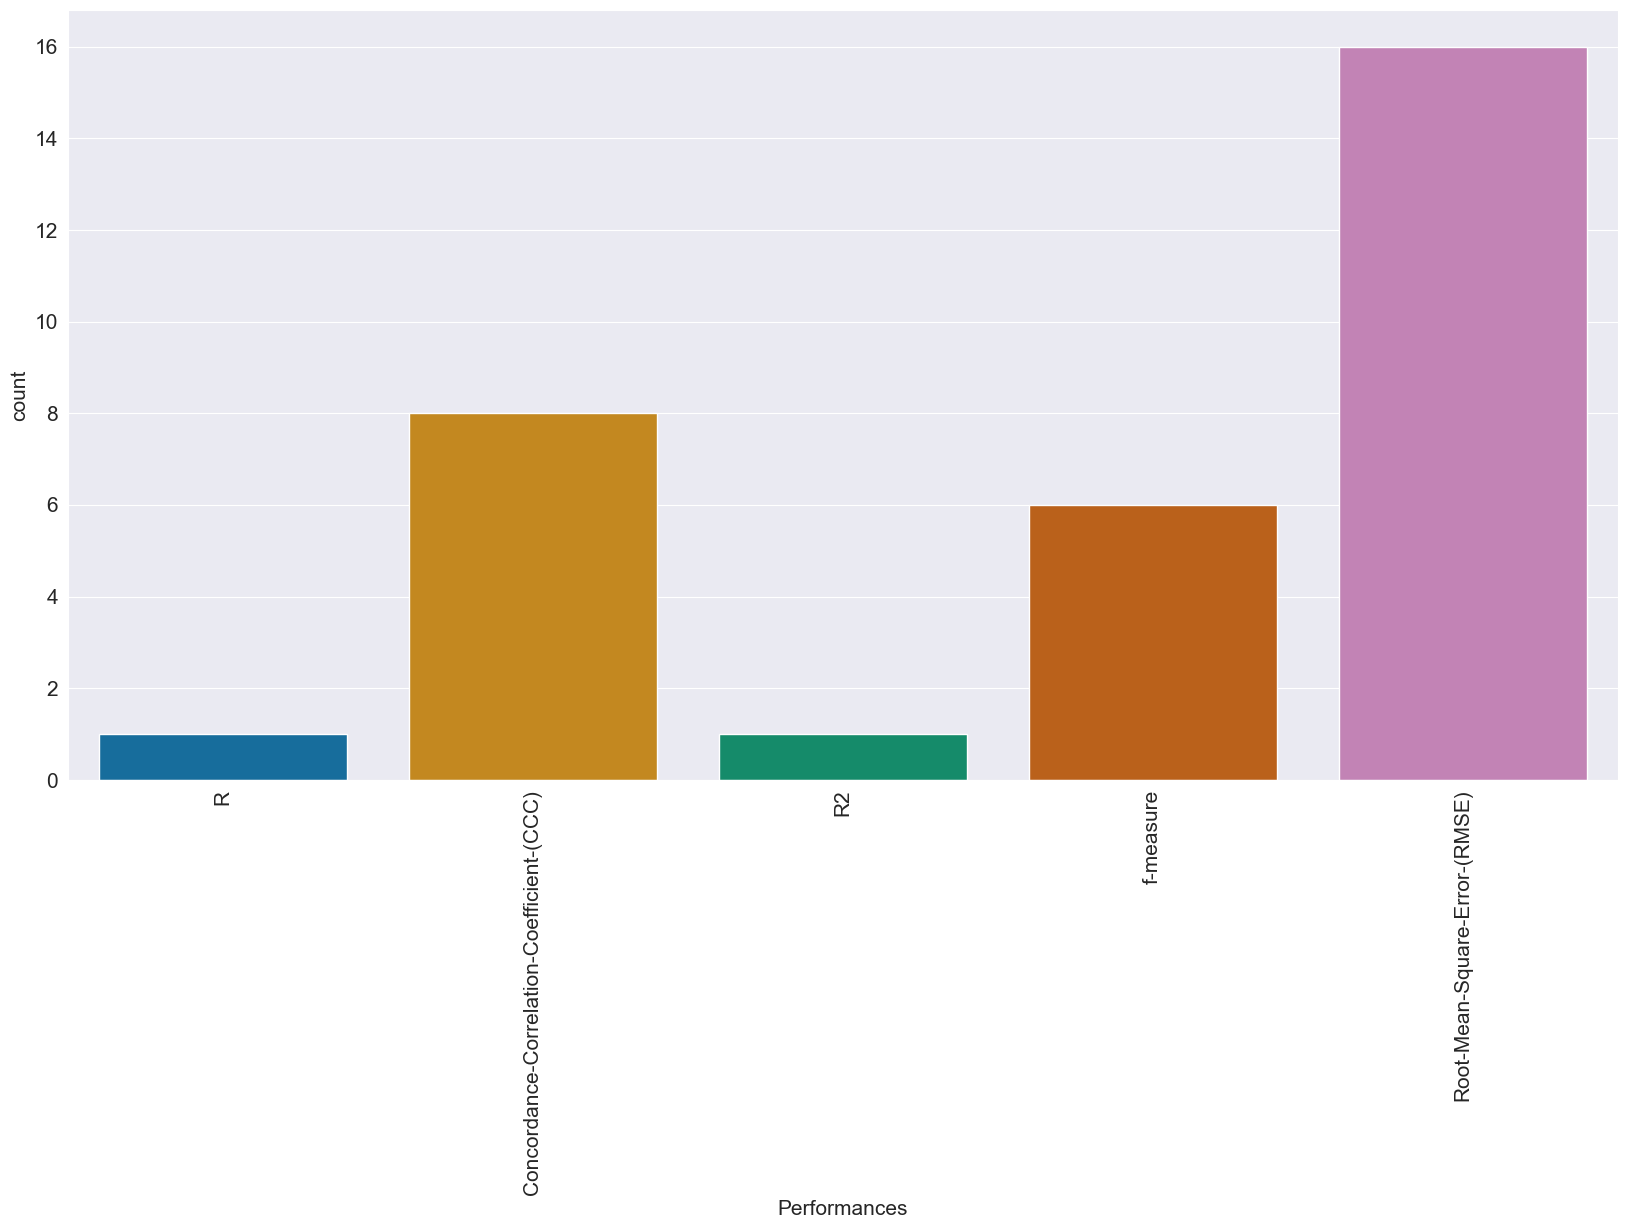

     paper_id  model_id                                       apa_citation  \
426      81.0     427.0  Zhang, K., Zhang, H., Li, S., Yang, C., & Sun,...   
427      81.0     428.0  Zhang, K., Zhang, H., Li, S., Yang, C., & Sun,...   
428      81.0     429.0  Zhang, K., Zhang, H., Li, S., Yang, C., & Sun,...   
429      81.0     430.0  Zhang, K., Zhang, H., Li, S., Yang, C., & Sun,...   
440      84.0     441.0  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
441      84.0     442.0  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
442      84.0     443.0  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
443      84.0     444.0  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
444      84.0     445.0  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
445      84.0     446.0  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
446      84.0     447.0  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
447      84.0     448.0  Zhang, L. K., Sun, S. Q., Xing, B. X., 

In [121]:
#creacion del data frames, y subseteo por: modelos dimensionales, tipo regressor, dimensiones arousal/valence
df = df_alg_perf
df = df[df['affective_model'] == 'dimensional']
df = df[df['is_regressor'].isin(['x', 'X'])]
df = df[df['regre_model_output_dimensions'].isin(['arousal', 'valence'])]

#que medida de performance mas aparece?
#dataframe con performances
df_performance_medidas = df.iloc[:,58:]

#print(df_performance_medidas)

#busqueda de la medida de performance mas recurrente, paso de los valores a 0 y 1 para facilitar su conteo
df_performance_medidas = df_performance_medidas.fillna('No')
df_performance_medidas = df_performance_medidas.replace('-', 'No')
df_performance_medidas=df_performance_medidas.mask(df_performance_medidas != 'No','Yes')

#obtener performance mas frecuente
def get_value(row):
    for c in df_performance_medidas.columns:
        if row[c] == 'Yes':
            return c

df_performance_medidas = df_performance_medidas.apply(get_value, axis=1)
df_performance_medidas = pd.DataFrame(df_performance_medidas)
df_performance_medidas.columns = ['Performances']

sns.countplot(x='Performances', data=df_performance_medidas)
plt.xticks(rotation=90)
plt.show()

#subseteo por la medida de performance que mas aparece (RMSE)
df = df.fillna('-')
df = df[df['Root-Mean-Square-Error-(RMSE)'] != '-']

print(df)
#la muestra es de 16 modelos

In [122]:

df_arousal = df[df['regre_model_output_dimensions'] == 'arousal']
df_arousal = df_arousal['Root-Mean-Square-Error-(RMSE)']
arousal = df_arousal.values.tolist()
arousal = list(map(float, arousal))

df_valence = df[df['regre_model_output_dimensions'] == 'valence']
df_valence = df_valence['Root-Mean-Square-Error-(RMSE)']
valence = df_valence.values.tolist()
valence = list(map(float, valence))

#Test parametrico - t de student
print('Students t-test')
from scipy.stats import ttest_ind
stat, p = ttest_ind(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


#Test no parametrico - U de Mann-Whitney
print('Mann-Whitney U Test')
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


Students t-test
stat=0.679, p=0.254
Probably the same distribution
Mann-Whitney U Test
stat=44.500, p=0.103
Probably the same distribution


##  (obsoleto) Cambios, teniendo en cuenta los resultados obtenidos en el analisis exploratorio y estadistico anterior

* Se partia del analisis hecho primeramente, sobre que la medida mas usada era UAR, y los papers sacados aca no corresponden con los que podrian ser ahora que se sabe cual es la mas frecuente (accuracy). Para actualizarse esta parte debe tenerse en cuenta eso.
* Nos quedamos solo con los modelos de clasificacion, y tenemos en cuenta los papers que posean ambos (High y Low para arousal y valencia)
* Solamente se dropearon dos papers, que testeaban solo modelos o de valencia o de arousal. Con esto se prosiguió con el análisis estadístico y los resultados fueron los mismos

In [123]:
"""
papers_titles = title_dimensions.drop_duplicates(subset='apa_citation')

#print(title_dimensions)
#Kołodziej, M., Tarnowski, P., Majkowski, A., &...   vuela
#Greco, A., Marzi, C., Lanata, A., Scilingo, E.

df_arousal = df_3[df_3['class_model_output_categories'] == 'HA, LA']
df_arousal = df_arousal['accuracy']
arousal = df_arousal.values.tolist()
arousal = list(map(float, arousal))

df_valence = df_3[df_3['class_model_output_categories'] == 'HV, LV']
df_valence = df_valence['accuracy']
valence = df_valence.values.tolist()
valence = list(map(float, valence))

#Test parametrico - t de student
print('Students t-test')
from scipy.stats import ttest_ind
stat, p = ttest_ind(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


#Test no parametrico - U de Mann-Whitney
print('Mann-Whitney U Test')
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')"""

"\npapers_titles = title_dimensions.drop_duplicates(subset='apa_citation')\n\n#print(title_dimensions)\n#Kołodziej, M., Tarnowski, P., Majkowski, A., &...   vuela\n#Greco, A., Marzi, C., Lanata, A., Scilingo, E.\n\ndf_arousal = df_3[df_3['class_model_output_categories'] == 'HA, LA']\ndf_arousal = df_arousal['accuracy']\narousal = df_arousal.values.tolist()\narousal = list(map(float, arousal))\n\ndf_valence = df_3[df_3['class_model_output_categories'] == 'HV, LV']\ndf_valence = df_valence['accuracy']\nvalence = df_valence.values.tolist()\nvalence = list(map(float, valence))\n\n#Test parametrico - t de student\nprint('Students t-test')\nfrom scipy.stats import ttest_ind\nstat, p = ttest_ind(arousal, valence, alternative = 'greater')\nprint('stat=%.3f, p=%.3f' % (stat, p))\nif p > 0.05:\n\tprint('Probably the same distribution')\nelse:\n\tprint('Probably different distributions')\n\n\n#Test no parametrico - U de Mann-Whitney\nprint('Mann-Whitney U Test')\nfrom scipy.stats import mannwhitn

Lo mismo pero con HAHV, HALV, LAHV, LALV

In [124]:

#creacion data frame y subseteo por: modelos dimensionales, tipo clasiffier, categorias HA/LA y HV/LV
df_hvlv_hala = df_alg_perf
df_hvlv_hala = df_hvlv_hala[df_hvlv_hala['affective_model'] == 'dimensional']
df_hvlv_hala = df_hvlv_hala[df_hvlv_hala['is_classifier'].isin(['x', 'X'])]
df_hvlv_hala = df_hvlv_hala[df_hvlv_hala['class_model_output_categories'].isin(['HAHV, HALV, LAHV, LALV'])]

#que medida de performance mas aparece en este grupo?
#dataframe con performances
title_dimensions_hvlv_hala = df_hvlv_hala[['apa_citation', 'class_model_output_categories']]

df_hvlv_hala_performances = df_hvlv_hala.iloc[:,58:]
df_hvlv_hala_performances = df_hvlv_hala_performances.fillna('-')

#subseteo por la medida de performance que mas aparece (accuracy)
df_hvlv_hala = df_hvlv_hala[df_hvlv_hala['accuracy'] != '-']

print(df_hvlv_hala)
df_ayv = df_hvlv_hala[df_hvlv_hala['class_model_output_categories'] == 'HAHV, HALV, LAHV, LALV']
df_ayv = df_ayv['accuracy']
hvlv_hala = df_ayv.values.tolist()
hvlv_hala = list(map(float, hvlv_hala))

print(hvlv_hala)

#Test parametrico - t de student
print('Students t-test')
from scipy.stats import ttest_ind
stat, p = ttest_ind(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


#Test no parametrico - U de Mann-Whitney
print('Mann-Whitney U Test')
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

     paper_id  model_id                                       apa_citation  \
4         4.0       5.0  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
5         4.0       6.0  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
6         4.0       7.0  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
7         4.0       8.0  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
8         4.0       9.0  Ali, M., Machot, F. A., Mosa, A. H., Jdeed, M....   
182      32.0     183.0  Siddharth,  null, Jung, T.-P., & Sejnowski, T....   
310      61.0     311.0  Al Machot, F., Elmachot, A., Ali, M., Al Macho...   
311      61.0     312.0  Al Machot, F., Elmachot, A., Ali, M., Al Macho...   
312      61.0     313.0  Al Machot, F., Elmachot, A., Ali, M., Al Macho...   
313      61.0     314.0  Al Machot, F., Elmachot, A., Ali, M., Al Macho...   
314      61.0     315.0  Al Machot, F., Elmachot, A., Ali, M., Al Macho...   
315      61.0     316.0  Al Machot, F., Elmachot, A., Ali, M., A

## Frecuencia de medidas de performance 

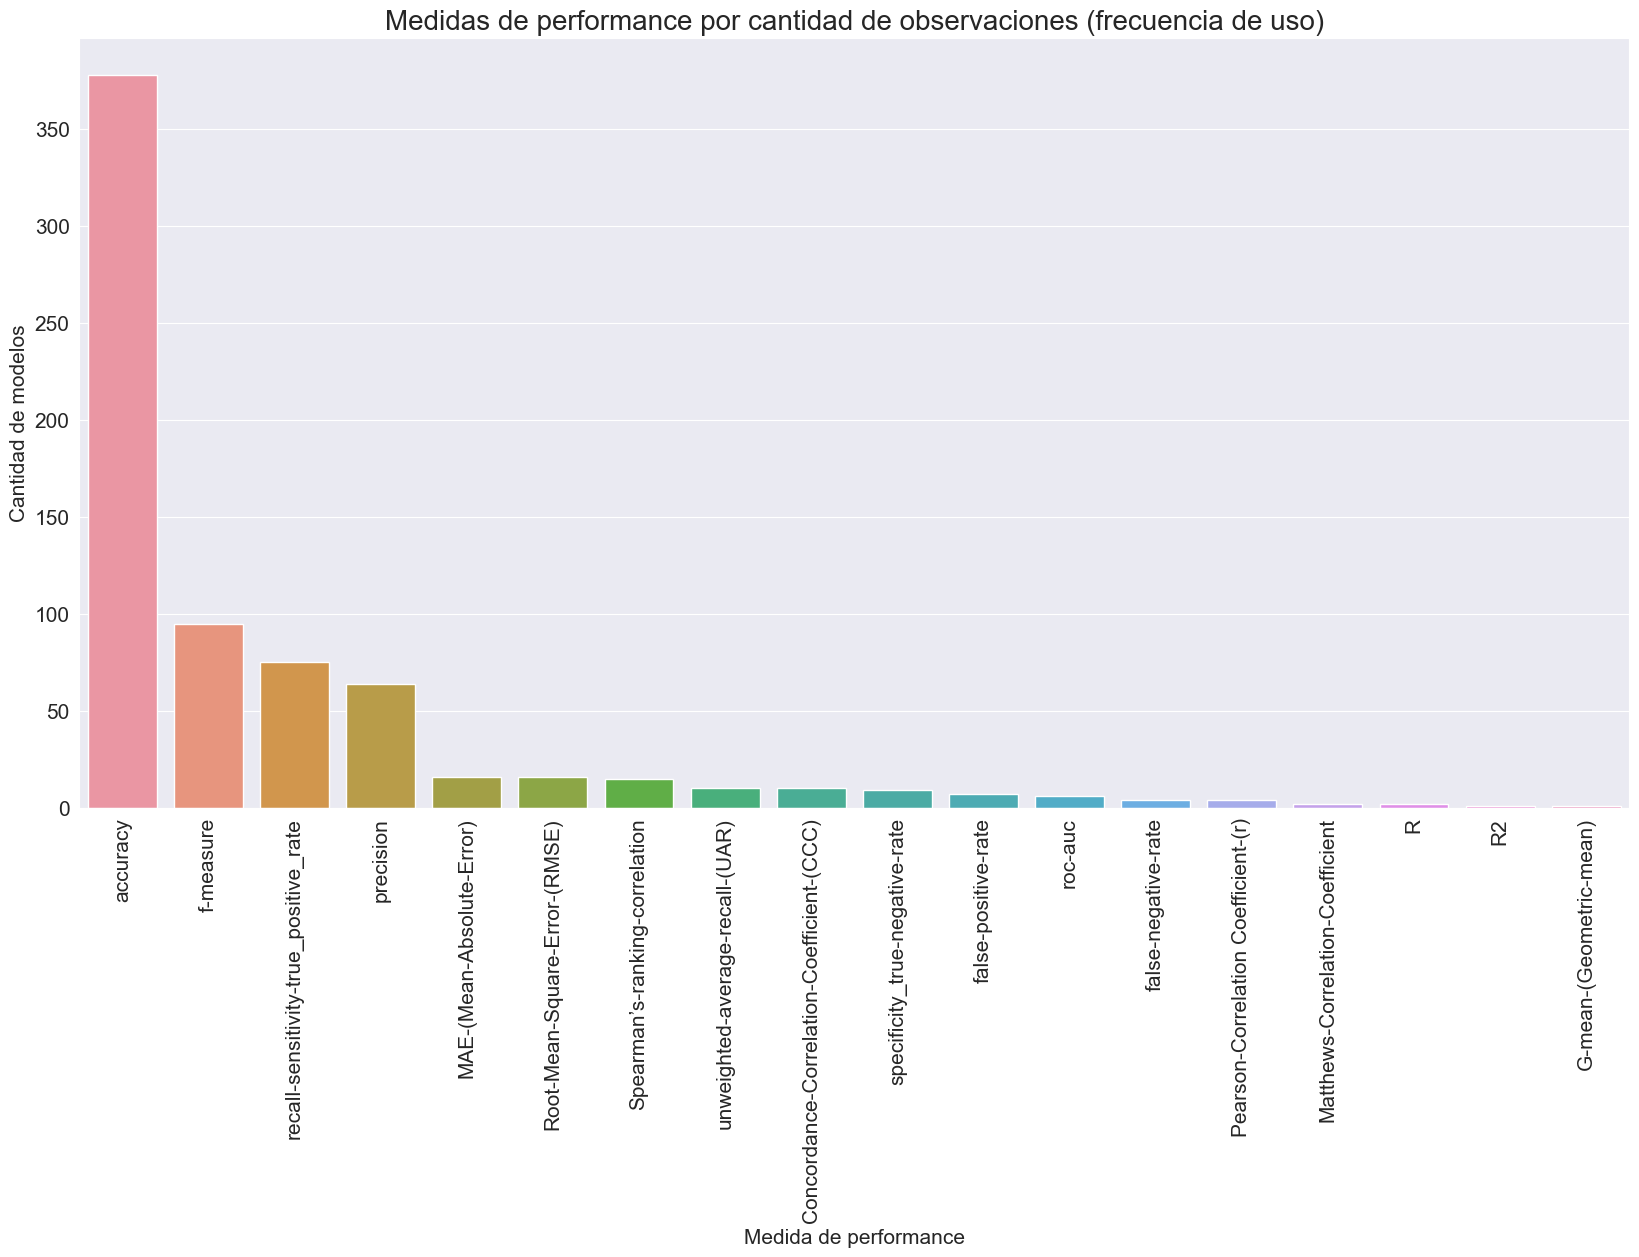

In [125]:
df_performances = df_performances.fillna('-')
df_performances = df_performances.drop([df_performances.index[143],df_performances.index[144],df_performances.index[145]])
df = multi_reversing_n(df_performances, 'model_id', df_performances.iloc[:,3:])
df = df[df['value'] != '-']

g = sns.countplot(x='variable', data=df, order=df.variable.value_counts().index)
g.set(title = 'Medidas de performance por cantidad de observaciones (frecuencia de uso)', xlabel = 'Medida de performance', ylabel = 'Cantidad de modelos')
plt.xticks(rotation=90)
plt.show()

In [126]:
def func(base,medida):
    performance = medida
    dataframe = base[base['variable'] == performance]
    dataframe = dataframe['value']

    lst = dataframe.values.tolist()
    lst = list(map(float, lst))
    return lst

f_measure = pd.DataFrame(func(df,'f-measure'))
accuracy = pd.DataFrame(func(df,'accuracy'))
#recall = pd.DataFrame(func(df,'recall-sensitivity-true_positive_rate'))
precision = pd.DataFrame(func(df,'precision'))
mae = pd.DataFrame(func(df,'MAE-(Mean-Absolute-Error)'))
rmse = pd.DataFrame(func(df,'Root-Mean-Square-Error-(RMSE)'))
spearman = pd.DataFrame(func(df,'Spearman’s-ranking-correlation'))
uar = pd.DataFrame(func(df,'unweighted-average-recall-(UAR)'))
ccc = pd.DataFrame(func(df,'Concordance-Correlation-Coefficient-(CCC)'))
#specificity = pd.DataFrame(func(df,'specificity_true-negative-rate'))
#false_pr = pd.DataFrame(func(df,'false-positive-rate'))
roc_auc = pd.DataFrame(func(df,'roc-auc'))
#false_negative_rate = pd.DataFrame(func(df,'false-negative-rate'))
pearson = pd.DataFrame(func(df,'Pearson-Correlation Coefficient-(r)'))
matthews = pd.DataFrame(func(df,'Matthews-Correlation-Coefficient'))
r = pd.DataFrame(func(df,'R'))
r2 = pd.DataFrame(func(df,'R2'))
g_mean = pd.DataFrame(func(df,'G-mean-(Geometric-mean)'))

In [127]:
performances = pd.DataFrame()

performances['accuracy'] = pd.Series(accuracy.iloc[:,0])
performances['f_measure'] = pd.Series(f_measure.iloc[:,0])
#performances['recall'] = pd.Series(recall.iloc[:,0])
performances['precision'] = pd.Series(precision.iloc[:,0])
performances['mae'] = pd.Series(mae.iloc[:,0])
performances['rmse'] = pd.Series(rmse.iloc[:,0])
performances['spearman'] = pd.Series(spearman.iloc[:,0])
performances['uar'] = pd.Series(uar.iloc[:,0])
performances['ccc'] = pd.Series(ccc.iloc[:,0])
#performances['specificity'] = pd.Series(specificity.iloc[:,0])
#performances['false_pr'] = pd.Series(false_pr.iloc[:,0])
performances['roc_auc'] = pd.Series(roc_auc.iloc[:,0])
#performances['false_negative_rate'] = pd.Series(false_negative_rate.iloc[:,0])
performances['pearson'] = pd.Series(pearson.iloc[:,0])
performances['matthews'] = pd.Series(matthews.iloc[:,0])
performances['r'] = pd.Series(r.iloc[:,0])
performances['r2'] = pd.Series(r2.iloc[:,0])
performances['g_mean'] = pd.Series(g_mean.iloc[:,0])

performances = pd.melt(performances)
performances = performances.fillna('-')
performances = performances[performances['value'] != '-']

[Text(0.5, 1.0, 'Comparacion performances de medidas de performance usadas')]

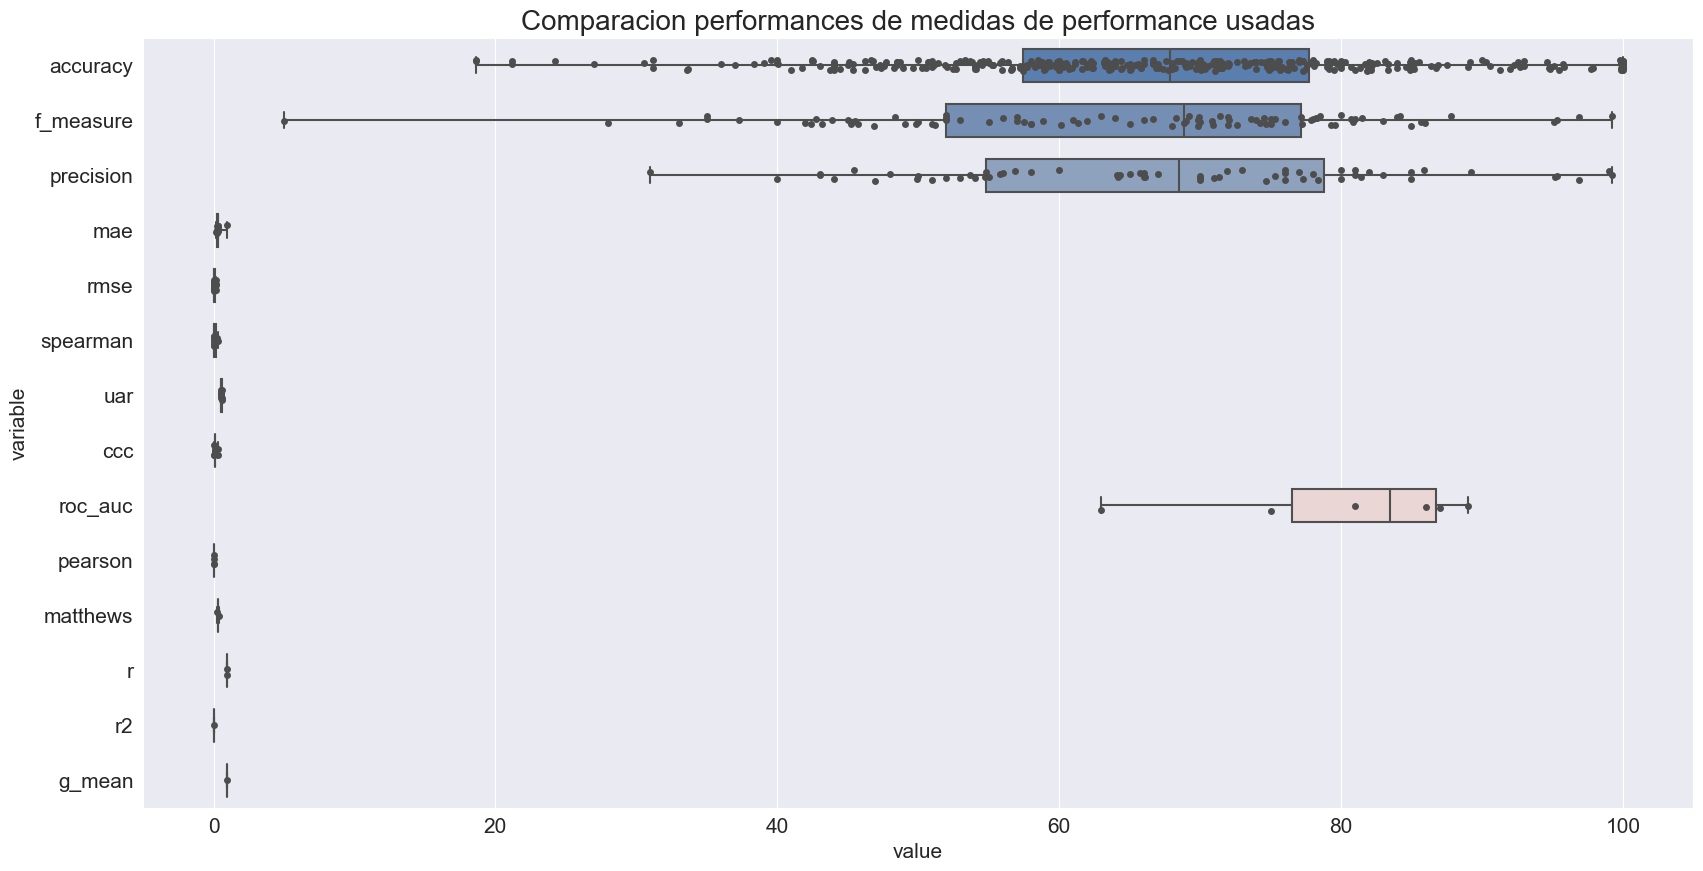

In [128]:
g = sns.boxplot(x='value', y='variable',data=performances,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x='value', y='variable',data=performances,
              size=5, color=".3", linewidth=0)
g.set(title = 'Comparacion performances de medidas de performance usadas')

In [129]:
accuracy = np.array(accuracy)
f_measure = np.array(f_measure)
#recall = np.array(recall)
precision = np.array(precision)
#Mean_ab_error = np.array(Mean_ab_error)
print(
    'accuracy:',np.mean(accuracy),', f-measure:',np.mean(f_measure),', recall:',np.mean(recall),', precision:',np.mean(precision),', mean absolute error:',np.mean(Mean_ab_error)
    )
list_performances = [np.mean(accuracy),np.mean(f_measure),np.mean(recall),np.mean(precision),np.mean(Mean_ab_error)]
list_performances

NameError: name 'recall' is not defined